# Task Description

In this tutorial, our aim is to compute the Fourier spectra within a specific window on the waveforms. This process involves a series of crucial pre-processing steps which enhance the quality of the data and ensure that the subsequent Fourier spectra analysis is applied at a specific portion of the seismic recordings. The pre-processing steps can be summarized as follows:


- Apply a bandpass filter (1 to 5 Hz) to eliminate unwanted noise from the seismic signal, ensuring that only the relevant frequency band is retained for further analysis.
- Select the P & S wave arrival times to define the edges of the signal and the noise windows later.
- Set the window edges according to the selected arrivals (signal window: from S arrival to S arrival plus window length, noise window: P arrival minus window length to P arrival).
- Cut the waveforms into signal and noise windows, created in relation to the P and S wave arrivals. Both windows will have a consistent duration (window length) of 10 seconds.
- Apply a smoothing algorithm (tapering) on the trimmed waveforms in order to ensure zero acceleration values at the edges.
- Compute the fourier spectra on the processed waveforms


# Reading the Input Data

In this article we will make use of the [ObsPy Python library](https://docs.obspy.org/) to apply the seismological computations and the [Python Matplotlib library](https://matplotlib.org/) to plot the waveform time series. For this reason, we will start by initializing the libraries that we will use throughout the rest of the article:

In [68]:
import matplotlib.pyplot as plt
from obspy.core import read, UTCDateTime
import numpy as np

To proceed, read a MiniSEED seismic file containing a record from June 17, 2017, at 19:49:50, recorded by the LMN1 station:

In [69]:
st = read("20170617_194950_LMN1.mseed")

To visually the waveforms, we will use the `plot()` method of the Stream object:

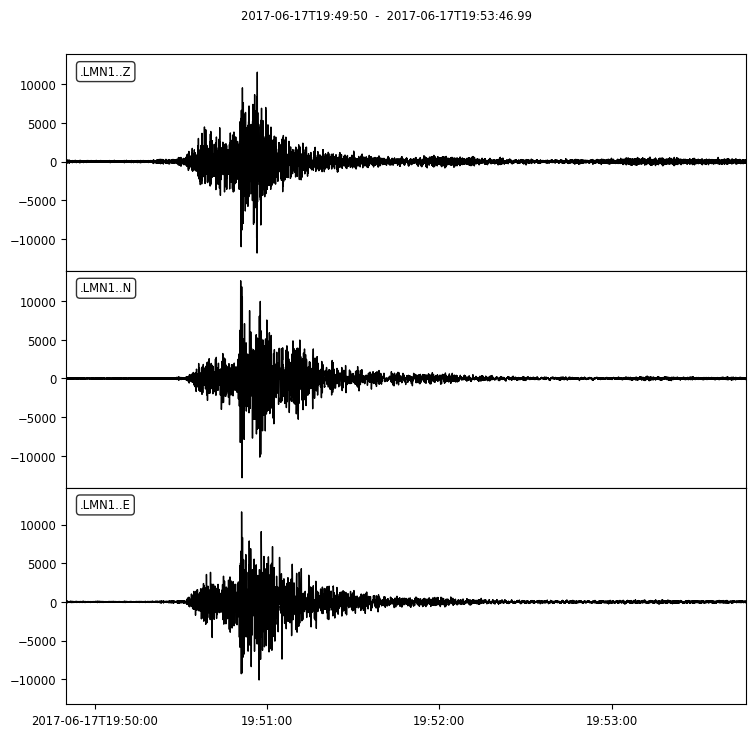

In [70]:
st.plot();

# Application Of the Pre-Processing Steps

## Apply A Bandpass Filter

Initiate the process by applying a bandpass filter to the records within the frequency range of 1 to 5 Hz. This step aims to eliminate surrounding noise and facilitate the arrival selection. Utilize the ObsPy `filter()` function for this purpose:

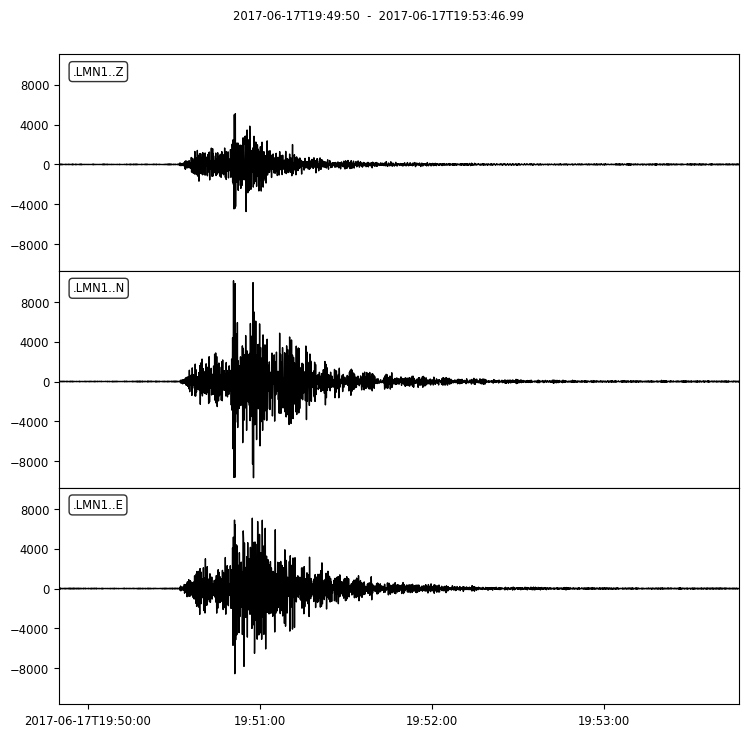

In [71]:
# apply an inplace bandpass filter of 1-5 Hz
st.filter('bandpass', freqmin=1, freqmax=5)

# plot the recordings
st.plot();

## Select The P And S Wave Arrivals

It's clear from the filtered waveforms, that the P wave arrivals occurs roughly at 19:50:35 and the S wave arrivals at 19:50:50. Convert these into ObsPy [UTCDateTime](https://docs.obspy.org/packages/autogen/obspy.core.utcdatetime.UTCDateTime.html) objects and convert the arrival values as total seconds from the starting date:

In [72]:
# Define the P and S wave arrivals as UTCDateTime objects
Parr = UTCDateTime('2017-06-17 19:50:32')
Sarr = UTCDateTime('2017-06-17 19:50:50')

# get the first trace 
first_trace = st.traces[0]

# Get the start date of the records from the first trace of the stream object
start_date = first_trace.stats.starttime

# Get the arrivals in seconds from the start date
Parr_sec = Parr - start_date
Sarr_sec = Sarr - start_date

To plot the P-wave and S-wave arrivals on the waveforms, we use Matplotlib to mark these time points with vertical lines. Here's an example of how you can do it in Python:

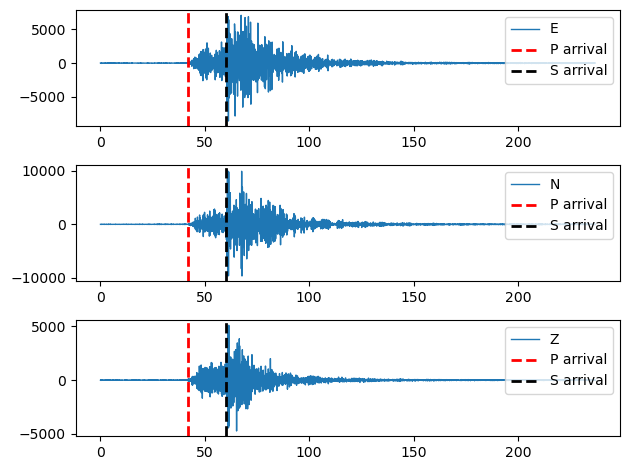

In [73]:
fig, ax = plt.subplots(len(st), 1)

# Loop through all the traces in the stream object (st)
for n, tr in enumerate(st):
    # get the time series time information of the current trace
    xdata = tr.times()

    # get the data of the current trace
    ydata = tr.data

    # plot the graph with legend, the trace component or channel
    ax[n].plot(xdata, ydata, label=tr.stats.channel, lw=1)

    # add two vertical lines that represent the arrivals
    ax[n].axvline(x=Parr_sec, ymin=0, ymax=1, lw=2, ls='--', color='red', label='P arrival')
    ax[n].axvline(x=Sarr_sec, ymin=0, ymax=1, lw=2, ls='--', color='black', label='S arrival')

    # add the legend on the plot
    ax[n].legend(loc='upper right')



# adjust the subplots so they do not overlap

plt.tight_layout()

## Define The Signal And Noise Windows

At this stage we define two windows to calculate the Fourier Spectra, one for the signal part of the waveform and one for the noise part. Both windows will share the same duration or length of 10 seconds. The first window will start from the S wave arrival and the second one will begin 10 seconds before the P wave arrival. Let's visualize these windows:

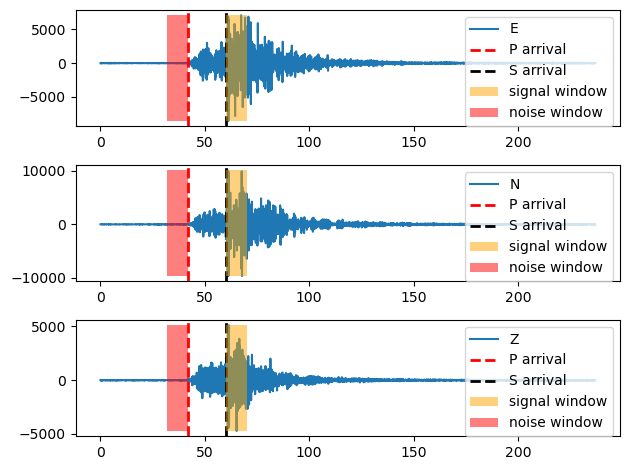

In [74]:
# set the window length
window_length = 10

# Initialize a matplotlib figure and axes with the total
# number of plots equal to the number of traces len(st)
fig, ax = plt.subplots(len(st), 1)

# Loop through all the traces in the stream object (st)
for n, tr in enumerate(st):
    # get the time series time information of the current trace
    xdata = tr.times()
    
    # get the data of the current trace
    ydata = tr.data

    # plot the graph with legend, the trace component or channel
    ax[n].plot(xdata, ydata, label=tr.stats.channel)

    # add two vertical lines that represent the arrivals
    ax[n].axvline(x=Parr_sec, ymin=0, ymax=1, lw=2, ls='--', color='red', label='P arrival')
    ax[n].axvline(x=Sarr_sec, ymin=0, ymax=1, lw=2, ls='--', color='black', label='S arrival')

    # get the min and max acceleration values
    min_y_value = tr.data.min()
    max_y_value = tr.data.max()

    # create the signal and the noise window on the waveforms
    ax[n].fill_betweenx([min_y_value,max_y_value], x1=Sarr_sec, x2=Sarr_sec+window_length, alpha=0.5, facecolor='orange', zorder=2, label='signal window')
    ax[n].fill_betweenx([min_y_value,max_y_value], x1=Parr_sec-window_length, x2=Parr_sec, alpha=0.5, facecolor='red', zorder=2, label='noise window')

    # add the legend on the plot
    ax[n].legend(loc='upper right')

# adjust the subplots so they do not overlap
plt.tight_layout()

## Trim The Waveforms Between The Windows

To continue, trim the waveforms at the two windows using the ObsPy `trim()` function. Because the trimming happens inplace, create copies of the orginal Stream object using the `copy()` method:

In [75]:
# noise window: from Parr-window_length to Parr
# signal window: from Sarr to Sarr+window_length
# Since the trim() function happens inplace, create new stream objects
# using the copy() function to trim the traces separately
st_signal = st.copy().trim(starttime=start_date+Sarr_sec, endtime=start_date+Sarr_sec+window_length)
st_noise = st.copy().trim(starttime=start_date+Parr_sec-window_length, endtime=start_date+Parr_sec)

Then plot the trimmed waveforms using the Matplotlib library:

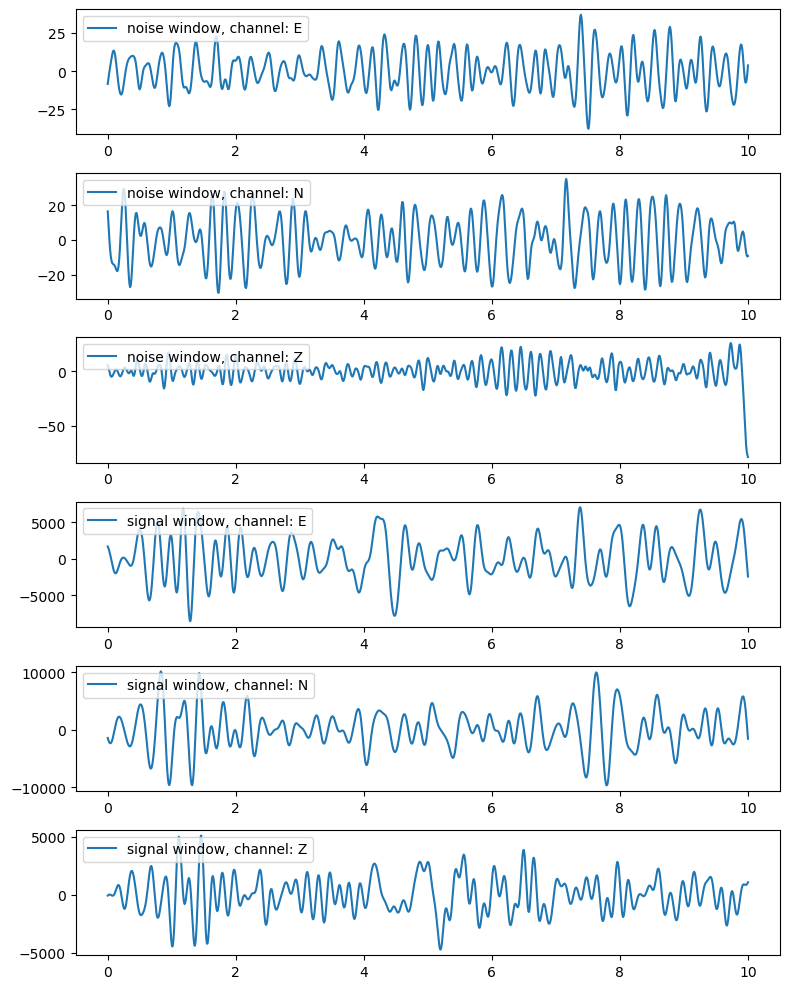

In [76]:
# Initialize a matplotlib figure and axes with the total  number of rows equal to 
# the number of traces plus 3 (3 signal traces and 3 noise traces)

fig, ax = plt.subplots(len(st)+3, 1, figsize=(8,10))

# Loop through all the traces in the noise Stream
# and plot them in the first 3 plots of the figure
for n, tr_noise in enumerate(st_noise):
    # get the time series time information as seconds from the starting date
    xdata = tr_noise.times()

    # get the data of the current trace
    ydata = tr_noise.data

    # plot the graph
    ax[n].plot(xdata, ydata, label=f'noise window, channel: {tr_noise.stats.channel}')

    # add the legend
    ax[n].legend(loc='upper left')


# Loop through all the traces in the signal Stream
# and plot them in the next 3 plots of the figure
for n, tr_signal in enumerate(st_signal, start=3):
    # get the time series time information as seconds from the starting date
    xdata = tr_signal.times()

    # get the data of the current trace
    ydata = tr_signal.data

    # plot the graph
    ax[n].plot(xdata, ydata, label=f'signal window, channel: {tr_signal.stats.channel}')

    # add the legend
    ax[n].legend(loc='upper left')

# adjust the subplots so they do not overlap
plt.tight_layout()

## Smooth the waveforms

At the last step, generate another copy of two obects from the previous trimmed recordings and smooth the left and the right side of the waveforms, using the obspy `taper()` function:

In [77]:
# taper the waveforms at the respective windows 30% on the left and 30% on the right side
# again use the copy() function to apply the taper on new stream object
st_signal_taper = st_signal.copy().taper(side='both', max_percentage=0.3)
st_noise_taper = st_noise.copy().taper(side='both', max_percentage=0.3)

Lastly, plot the results using Matplotlib:

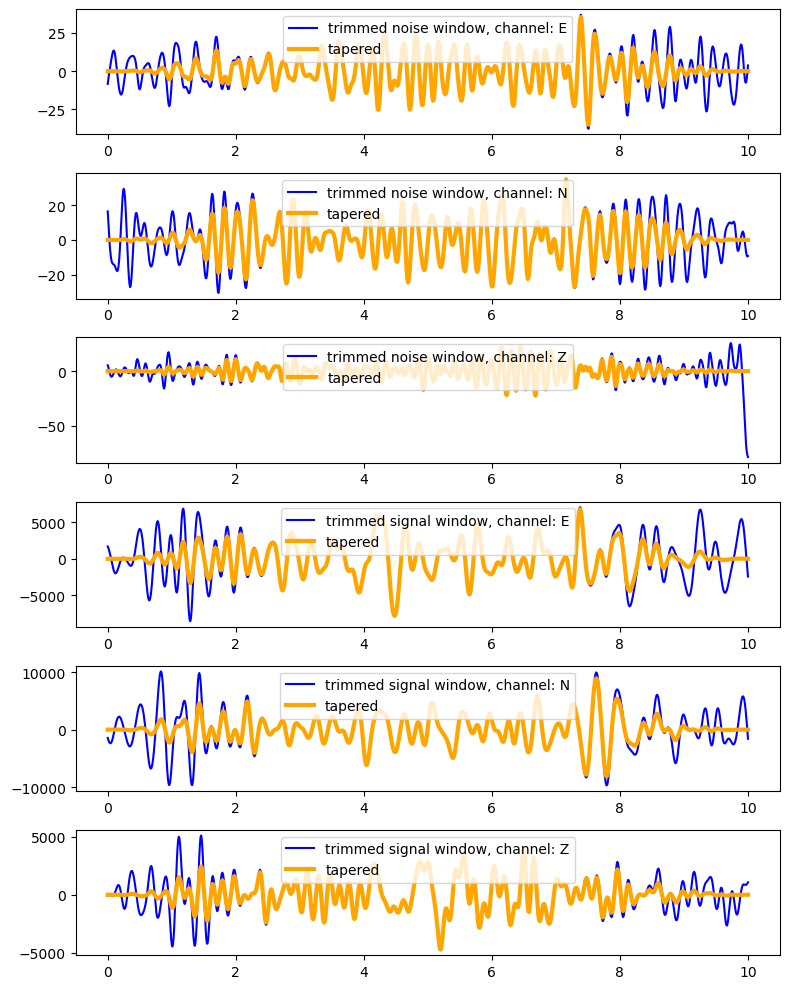

In [78]:
# Initialize a matplotlib figure and axes with the total  number of rows equal to 
# the number of traces plus 3 (3 signal traces and 3 noise traces)

fig, ax = plt.subplots(len(st)+3, 1, figsize=(8,10))
# Loop through the number of traces in the noise Stream object

for i in range(len(st_noise)):
    # plot the trimmed waveforms with blue color
    ax[i].plot(st_noise[i].times(), st_noise[i].data, label=f'trimmed noise window, channel: {st_noise[i].stats.channel}', color="blue")

    # plot the tapered waveforms with orange color
    ax[i].plot(st_noise_taper[i].times(), st_noise_taper[i].data, label='tapered', lw=3, color="orange")

    # add the legend
    ax[i].legend(loc='upper center')

# Loop through the number of traces in the signal Stream object
for i in range(len(st_signal)):
    # plot the trimmed waveforms with blue color
    ax[i+3].plot(st_signal[i].times(), st_signal[i].data, label=f'trimmed signal window, channel: {st_signal[i].stats.channel}', color="blue")

    # plot the tapered waveforms with orange color
    ax[i+3].plot(st_signal_taper[i].times(), st_signal_taper[i].data, label='tapered', lw=3, color="orange")

    # add the legend
    ax[i+3].legend(loc='upper center')


# adjust the subplots so they do not overlap
plt.tight_layout()

# Compute The Fourier Spectra

Finally, we can calculate the Fourier Spectra at the noise and the signal window:

In [79]:
# get the first trace of the signal Stream object
first_trace = st_signal_taper[0]

# get the starting date of the recordings
starttime = first_trace.stats.starttime

# get the sampling frequency and the sample distance
fs = first_trace.stats["sampling_rate"]
delta = first_trace.stats["delta"]

# calculate the nyquist frequency
fnyq = fs / 2

# initialize a dictionary to save the outputs
fourier_data_dict = {}

# loop through the traces
for i in range(len(st_signal_taper)):
    # get a copy of the trace for the singal
    df_s = st_signal_taper[i].copy()

    # get the current trace channel
    channel = df_s.stats.channel

    # get the number of sample points after the trimming
    npts = df_s.stats["npts"]

    # calculate the number of frequencies on the frequency spectra
    sl = int(npts / 2)

    # calculate the frequnecy array to plot the fourier
    freq_x = np.linspace(0 , fnyq , sl)

    # save the frequencies in a variable to use it later at the plotting
    xdata = freq_x

    # compute the fft of the signal
    yf_s = np.fft.fft(df_s.data[:npts]) 
    y_write_s = delta * np.abs(yf_s)[0:sl]

    # do the same also for the noise part
    # get a copy of the trace for the noise
    df_p = st_noise_taper[i].copy()

    # calculate the fft
    yf_p = np.fft.fft(df_p.data[:npts]) 
    y_write_p = delta * np.abs(yf_p)[0:sl]

    # add the fft of the signal and noise part to the dictionary for the current trace
    fourier_data_dict[channel] = {"signal": y_write_s, "noise": y_write_p}

And we present the results:

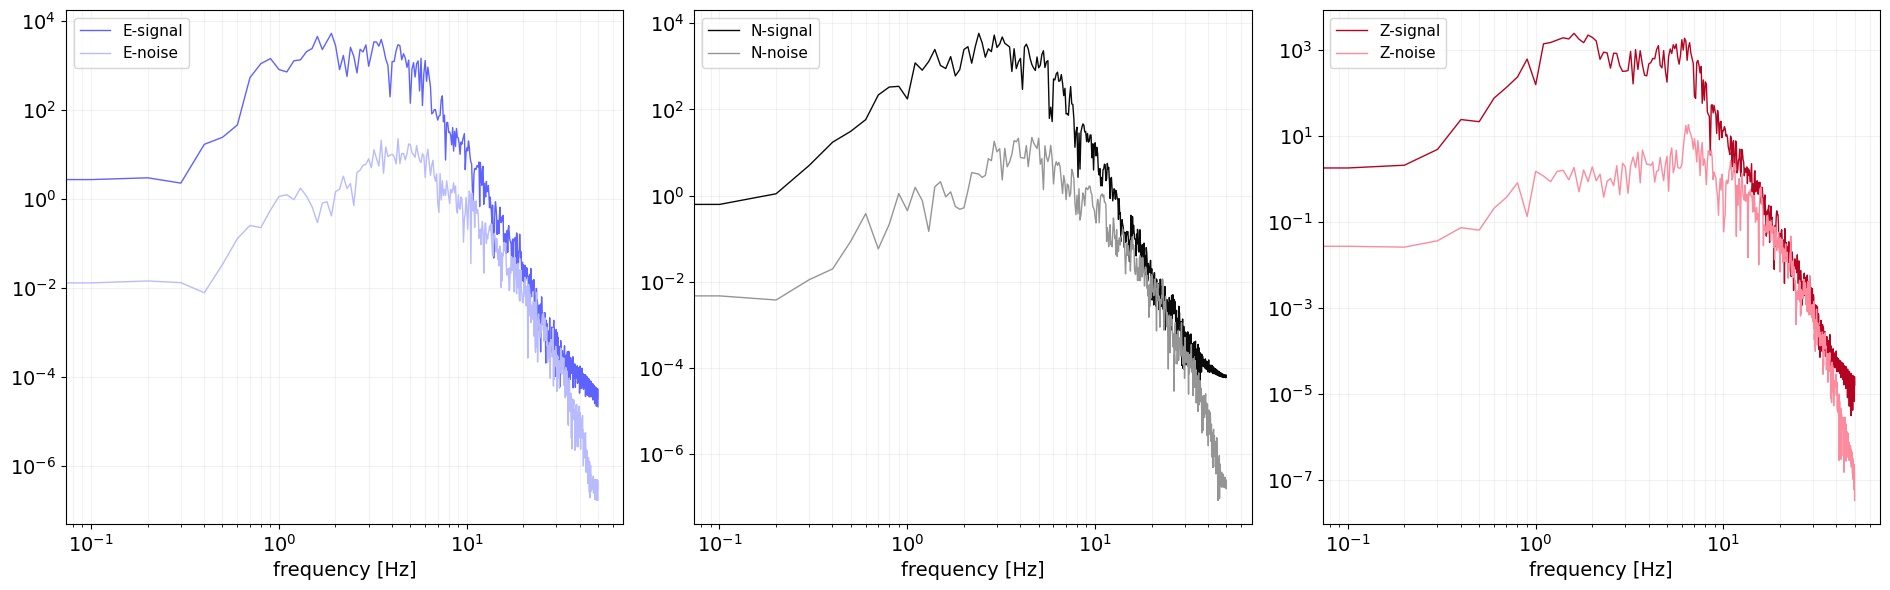

In [80]:
# initialize a Matplotlib figure to plot the Fourier data
figfourier, axfourier = plt.subplots(1, len(fourier_data_dict),  figsize=(19,6))

# create a hex colors list to style the curves
colors = ['#5E62FF', '#B9BBFF', '#0a0a0a', '#969595', '#b50421', '#fc8b9e']
color_i = 0

# loop through each component at the dictionary
for n, compo in enumerate(fourier_data_dict):

    # loop through the 'noise' and the 'signal' part
    for s_n in fourier_data_dict[compo]:
        # define the ydata with data located in the dictionary created earlier
        ydata = fourier_data_dict[compo][s_n]

        # create a variable to save the legend name of the curves
        label_name = f"{compo}-{s_n}"
        
        # plot the frequencies and the data
        axfourier[n].plot(xdata, ydata, color=colors[color_i], lw=1, label=label_name)
        color_i += 1

    # style the graphs 
    axfourier[n].legend(loc='upper left', fontsize=11, facecolor='w')
    axfourier[n].set_xscale('log')
    axfourier[n].set_yscale('log')
    axfourier[n].set_xlabel("frequency [Hz]", fontsize=14)
    axfourier[n].grid(color='grey', ls='-', which='both', alpha=0.1)
    axfourier[n].tick_params(axis='both', which='both', labelsize=14)


plt.tight_layout()